In [1]:
#import package
from pyspark.sql.functions import col
from pyspark.sql import SparkSession
import csv
from pyspark.sql.functions import col, create_map, lit
from itertools import chain
from pyspark.sql.window import Window
import pyspark.sql.functions as F
from pyspark.sql.functions import row_number
from pyspark.sql.functions import array, col, explode, struct, lit
from pyspark.sql.functions import udf
from pyspark.sql.types import MapType, StringType, IntegerType
from collections import Counter

# The variable names inside the notebook are consistent with the notebook for Question 1 - Question 6.

# Q7

In [3]:
# First, create your dependent variable Y , i.e. the total number of transactions at lifetime point 12. In other words, 
# for every user, you need to count how many transactions s/he had committed during her/his twelve months in Venmo.
venmo = spark.read.parquet("part-00000-tid-7256543852422054536-4470da3a-e616-49b4-a42c-29cd0acc0b45-20673-1-c000.snappy.parquet")

In [4]:
venmo.createOrReplaceTempView("venmo")
venmo_Y = spark.sql("""SELECT * FROM venmo where month_passed <= 12""")

In [5]:
window = Window.partitionBy('user')
venmo_Y = venmo_Y.select("user","datetime","month_passed").withColumn("Y", F.count(venmo_Y['datetime']).over(window))
venmo_Y = venmo_Y.withColumn("transaction", lit(1))
venmo_Y.sort('user','month_passed').show()

+----+-------------------+------------+---+-----------+
|user|           datetime|month_passed|  Y|transaction|
+----+-------------------+------------+---+-----------+
|   2|2012-11-22 22:03:42|           0|  1|          1|
|   3|2016-09-22 08:30:09|           0|  6|          1|
|   3|2016-10-07 16:37:56|           1|  6|          1|
|   3|2016-10-08 18:56:24|           1|  6|          1|
|   3|2016-10-07 01:50:23|           1|  6|          1|
|   3|2016-10-06 03:49:45|           1|  6|          1|
|   3|2016-10-08 20:36:13|           1|  6|          1|
|   4|2012-12-02 19:35:53|           0|  2|          1|
|   4|2012-12-14 21:51:12|           1|  2|          1|
|   8|2015-08-10 19:08:47|           0|  4|          1|
|   8|2016-03-01 23:35:34|           7|  4|          1|
|   8|2016-04-17 22:46:42|           9|  4|          1|
|   8|2016-05-16 18:18:05|          10|  4|          1|
|   9|2012-06-27 21:28:32|           0|  5|          1|
|   9|2012-08-12 23:00:53|           2|  5|     

# Q8

In [6]:
# Left join the entire month period for each user
venmo.createOrReplaceTempView("Venmo")
month_cycle = spark.sql("""SELECT distinct v.user,sub.month
             FROM Venmo v CROSS JOIN (select 0 as month union all select 1 as month union all select 2 union all select 3 union all select 4 union all select 5 union all select 6 union all select 7 union all select 8 union all select 9 union all select 10 union all select 11 union all select 12) as sub
            ORDER BY v.user,sub.month""")

In [7]:
# Prepare the dataframe structure for calsulating rencency and frequency
venmo_Y = venmo_Y.groupBy('user','month_passed','Y').agg(F.max('datetime').alias('datetime'),F.sum('transaction').alias('transaction'))
venmo_Y.createOrReplaceTempView("venmo_Y")
month_cycle.createOrReplaceTempView("month_cycle")
venmo_Y_recency_prep = spark.sql("""
                SELECT l.user, l.month, v.datetime, v.Y, v.transaction
                FROM month_cycle l LEFT JOIN venmo_Y v
                ON l.user = v.user AND l.month = v.month_passed
                """)

In [8]:
import pyspark.sql.functions as func
import sys
from pyspark.sql.functions import expr
# Filled the null value of datetime
venmo_Y_recency_prep_filled = venmo_Y_recency_prep.withColumn("datetime", func.last('datetime', True).over(Window.partitionBy('user').orderBy('month').rowsBetween(-sys.maxsize, 0)))
# Filled the null value of Y
venmo_Y_recency_prep_filled = venmo_Y_recency_prep_filled.withColumn("Y",F.max(venmo_Y_recency_prep_filled["Y"]).over(Window.partitionBy('user')))
# Create variable indicating the users' first purchasing time
venmo_Y_recency_prep_filled = venmo_Y_recency_prep_filled.withColumn("first_purchase",F.min(venmo_Y_recency_prep_filled["datetime"]).over(Window.partitionBy('user')))
# Create variable indicating whether there exists transaction or not
define_transaction = expr("""IF(transaction IS NULL, 0, transaction)""")
venmo_Y_recency_prep_filled = venmo_Y_recency_prep_filled.withColumn("transaction",define_transaction)
venmo_Y_recency_prep_filled = venmo_Y_recency_prep_filled.cache()

In [9]:
# Create the recency variables.
venmo_Y_recency = venmo_Y_recency_prep_filled.withColumn("recency",30*venmo_Y_recency_prep_filled['month']-F.datediff(venmo_Y_recency_prep_filled['datetime'],venmo_Y_recency_prep_filled['first_purchase']))

In [10]:
# Create the frequency variables.
venmo_Y_recency_frequency = venmo_Y_recency.withColumn("frequency",F.sum(venmo_Y_recency['transaction']).over(Window.partitionBy('user').orderBy('month').rangeBetween(Window.unboundedPreceding,0))/(30*venmo_Y_recency['month']))
# Filled the null value for interval 0 with frequency 1
define_frequency = expr("""IF(frequency IS NULL, 1, frequency)""")
venmo_Y_recency_frequency = venmo_Y_recency_frequency.withColumn("frequency",define_frequency)
venmo_Y_recency_frequency.sort('user','month').show(1000)

+----+-----+-------------------+---+-----------+-------------------+-------+--------------------+
|user|month|           datetime|  Y|transaction|     first_purchase|recency|           frequency|
+----+-----+-------------------+---+-----------+-------------------+-------+--------------------+
|   2|    0|2012-11-22 22:03:42|  1|          1|2012-11-22 22:03:42|      0|                 1.0|
|   2|    1|2012-11-22 22:03:42|  1|          0|2012-11-22 22:03:42|     30| 0.03333333333333333|
|   2|    2|2012-11-22 22:03:42|  1|          0|2012-11-22 22:03:42|     60|0.016666666666666666|
|   2|    3|2012-11-22 22:03:42|  1|          0|2012-11-22 22:03:42|     90|0.011111111111111112|
|   2|    4|2012-11-22 22:03:42|  1|          0|2012-11-22 22:03:42|    120|0.008333333333333333|
|   2|    5|2012-11-22 22:03:42|  1|          0|2012-11-22 22:03:42|    150|0.006666666666666667|
|   2|    6|2012-11-22 22:03:42|  1|          0|2012-11-22 22:03:42|    180|0.005555555555555556|
|   2|    7|2012-11-

# Q9

In [14]:
venmo_reg = spark.read.parquet("venmo_reg.parquet")

In [12]:
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.regression import LinearRegression
from pyspark.ml.tuning import ParamGridBuilder, TrainValidationSplit
from pyspark.ml.feature import VectorAssembler

In [17]:
# Change the dataframe into the model suitable format
vectorAssembler = VectorAssembler(inputCols = ['recency', 'frequency'], outputCol = 'features')
venmo_reg_agg = vectorAssembler.transform(venmo_reg)

In [88]:
# Train and test split
for i in range(0,13):
    splits = venmo_reg_agg[venmo_reg_agg['month']==i].randomSplit([0.7, 0.3])
    train = splits[0].select(['features','Y'])
    test = splits[1].select(['features','Y'])
    train_df = train.withColumnRenamed('Y','label')
    test_df = test.withColumnRenamed('Y','label')
    train_df.write.parquet("train_df_month"+str(i)+".parquet", mode='overwrite')
    test_df.write.parquet("test_df_month"+str(i)+".parquet", mode='overwrite')

In [93]:
MSE_list = []
for i in range(0,13):  
    # For each user’s lifetime point, regress recency and frequency on Y. 
    lr = LinearRegression(featuresCol='features', labelCol='label', maxIter=10)

    # We use a ParamGridBuilder to construct a grid of parameters to search over.
    # TrainValidationSplit will try all combinations of values and determine best model using the evaluator.
    paramGrid = ParamGridBuilder()\
        .addGrid(lr.regParam, [0.1, 0.01]) \
        .addGrid(lr.elasticNetParam, [0.0, 0.5, 1.0])\
        .build()

    # A TrainValidationSplit requires an Estimator, a set of Estimator ParamMaps, and an Evaluator.
    tvs = TrainValidationSplit(estimator=lr,
                               estimatorParamMaps=paramGrid,
                               evaluator=RegressionEvaluator(),
                               # 80% of the data will be used for training, 20% for validation.
                               trainRatio=0.8)

    # Run TrainValidationSplit, and choose the best set of parameters.
    train_df = spark.read.parquet("train_df_month"+str(i)+".parquet")
    test_df = spark.read.parquet("test_df_month"+str(i)+".parquet")
    model = tvs.fit(train_df)
    
    # Out of Sample Mean Squared Error
    lr_predictions = model.transform(test_df)
    evaluator = RegressionEvaluator(metricName="mse")
    MSE = evaluator.evaluate(lr_predictions)
    MSE_list.append(MSE)
    
    #
    print(i)
    print(model.bestModel._java_obj.getRegParam())
    print(model.bestModel._java_obj.getElasticNetParam())
    print("Coefficients: " + str(model.bestModel.coefficients))

0
0.1
0.0
Coefficients: [0.0,0.0]
1
0.01
0.0
Coefficients: [-0.01245247102662075,51.62855202037519]
2
0.01
0.0
Coefficients: [-0.007299140366935398,95.46337701713504]
3
0.01
1.0
Coefficients: [-0.005507400323503031,131.6633396172256]
4
0.01
1.0
Coefficients: [-0.00447780120811812,164.56709766316155]
5
0.01
1.0
Coefficients: [-0.0032315864193373928,198.2873461771559]
6
0.01
0.0
Coefficients: [-0.003039788848970825,221.8432512143228]
7
0.01
0.0
Coefficients: [-0.0023735474869233295,247.58575152291968]
8
0.01
1.0
Coefficients: [-0.0016369421371689094,273.03507911435867]
9
0.01
1.0
Coefficients: [-0.0011697143427751044,296.4759136438669]
10
0.01
0.5
Coefficients: [-0.0008350108927792781,317.76003691801725]
11
0.01
1.0
Coefficients: [-0.000319963611097445,340.3444952059878]
12
0.01
1.0
Coefficients: [0.0,358.26955894900436]


In [90]:
# Plot the MSE for each lifetime point. In other words, your x-axis will be lifetime in months (0-12), and your
# y-axis will be the MSE. ( Hint : Don’t forget to split your data into train and test sets).

In [94]:
MSE_list

[4.327612283304976,
 3.6270907598449322,
 3.0129811974162863,
 2.508636757608931,
 2.1025957306791256,
 1.648608039254667,
 1.2930645662478633,
 0.9566643727882806,
 0.6734118023493263,
 0.44915612044812386,
 0.26404319312465857,
 0.11001946205677665,
 9.767585390037166e-05]

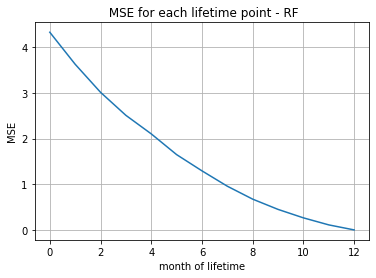

In [16]:
import matplotlib.pyplot as plt

month_list = [0,1,2,3,4,5,6,7,8,9,10,11,12]
MSE_list_RF = MSE_list
fig, ax = plt.subplots()
ax.plot(month_list, MSE_list_RF)

ax.set(xlabel='month of lifetime', ylabel='MSE',
       title=' MSE for each lifetime point - RF')
ax.grid()

plt.show()

# Q10

In [97]:
# For each user’s lifetime point, regress recency, frequency AND her spending behavior profile on Y.

In [90]:
accum_profile_prop = spark.read.parquet('part-00000-tid-9122028895436352275-86880ce4-a9db-42bb-8b17-e8e4a705b692-19664-1-c000.snappy.parquet')
print((accum_profile_prop.count(), len(accum_profile_prop.columns)))

(29224312, 12)


In [98]:
venmo_reg_sb = venmo_reg.join(accum_profile_prop,['user','month'],how ='inner').orderBy('user','month').cache()

In [99]:
venmo_reg_sb.show()

+----+-----+-------------------+---+-----------+-------------------+-------+--------------------+-------------+---------+------------+-----------+-----------+------------+---------+----------+-----------+-----------+
|user|month|           datetime|  Y|transaction|     first_purchase|recency|           frequency|activity_perc|food_perc|illegal_perc|others_perc|people_perc|utility_perc|cash_perc|event_perc|transp_perc|travel_perc|
+----+-----+-------------------+---+-----------+-------------------+-------+--------------------+-------------+---------+------------+-----------+-----------+------------+---------+----------+-----------+-----------+
|   2|    0|2012-11-22 22:03:42|  1|          1|2012-11-22 22:03:42|      0|                 1.0|          0.0|      0.0|         0.0|        1.0|        0.0|         0.0|      0.0|       0.0|        0.0|        0.0|
|   2|    1|2012-11-22 22:03:42|  1|          0|2012-11-22 22:03:42|     30| 0.03333333333333333|          0.0|      0.0|         0.

In [100]:
# Change the dataframe into the model suitable format
vectorAssembler = VectorAssembler(inputCols = ['activity_perc','food_perc','illegal_perc','others_perc','people_perc','utility_perc','cash_perc','event_perc','transp_perc','travel_perc','recency','frequency'], outputCol = 'features')
venmo_reg_sb_agg = vectorAssembler.transform(venmo_reg_sb)

In [101]:
# Train and test split
for i in range(0,13):
    splits = venmo_reg_sb_agg[venmo_reg_sb_agg['month']==i].randomSplit([0.7, 0.3])
    train = splits[0].select(['features','Y'])
    test = splits[1].select(['features','Y'])
    train_df = train.withColumnRenamed('Y','label')
    test_df = test.withColumnRenamed('Y','label')
    train_df.write.parquet("train_df_sb_month"+str(i)+".parquet", mode='overwrite')
    test_df.write.parquet("test_df_sb_month"+str(i)+".parquet", mode='overwrite')

In [102]:
MSE_list = []
for i in range(0,13):  
    # For each user’s lifetime point, regress recency, frequency AND her spending behavior profile on Y.
    lr = LinearRegression(featuresCol='features', labelCol='label', maxIter=10)

    # We use a ParamGridBuilder to construct a grid of parameters to search over.
    # TrainValidationSplit will try all combinations of values and determine best model using the evaluator.
    paramGrid = ParamGridBuilder()\
        .addGrid(lr.regParam, [0.1, 0.01]) \
        .addGrid(lr.fitIntercept, [False, True])\
        .addGrid(lr.elasticNetParam, [0.0, 0.5, 1.0])\
        .build()

    # A TrainValidationSplit requires an Estimator, a set of Estimator ParamMaps, and an Evaluator.
    tvs = TrainValidationSplit(estimator=lr,
                               estimatorParamMaps=paramGrid,
                               evaluator=RegressionEvaluator(),
                               # 80% of the data will be used for training, 20% for validation.
                               trainRatio=0.8)

    # Run TrainValidationSplit, and choose the best set of parameters.
    train_df = spark.read.parquet("train_df_sb_month"+str(i)+".parquet")
    test_df = spark.read.parquet("test_df_sb_month"+str(i)+".parquet")
    model = tvs.fit(train_df)
    
    # Out of Sample Mean Squared Error
    lr_predictions = model.transform(test_df)
    evaluator = RegressionEvaluator(metricName="mse")
    MSE = evaluator.evaluate(lr_predictions)
    MSE_list.append(MSE)
    
    #
    print(i)
    print("Coefficients: " + str(model.bestModel.coefficients))

0
Coefficients: [-0.31838868141754284,0.1424924566847431,0.37691899150525604,0.035084514602399,0.0314052634966444,0.094424572930396,-0.16423955090244682,-0.25480143487343304,0.010308184966802149,-0.34338314817372906,0.0,0.0]
1
Coefficients: [-0.1815411619318754,0.1755390095545538,0.5172343175961119,0.058268810512889166,0.039939847889589535,-0.06688495686925768,-0.1550426556743651,-0.15722448230262315,-0.10690892328832467,-0.6356737976689635,-0.010792963833250208,51.541813474265865]
2
Coefficients: [-0.273318678818455,0.15320995303809523,0.37168891385474967,-0.004089391641881243,-0.0678231252649019,-0.13060806570499817,-0.04943223779185267,-0.13056413933723232,-0.1192025464913018,-0.4298814401697719,-0.009423649471760043,91.94046948808767]
3
Coefficients: [-0.11812119237833338,0.20019116935594605,0.3528364328668005,0.08304638312786743,-0.0037215863747807956,-0.07450889882849511,-0.1135031449269228,-0.09341339673263796,0.009039490651915697,-0.42280249188104124,-0.00815127286985204,119.61

In [103]:
MSE_list

[4.205888133830025,
 3.5839874494967017,
 3.0897669198790783,
 2.5571167101567904,
 2.087730588359663,
 1.6441836259173197,
 1.2611961214422809,
 0.9403375364533834,
 0.7040253745600606,
 0.4483085978254978,
 0.2703274270016875,
 0.10987088998986431,
 4.5151475988802364e-05]

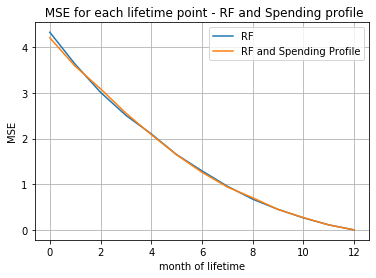

In [19]:
import matplotlib.pyplot as plt

month_list = [0,1,2,3,4,5,6,7,8,9,10,11,12]
MSE_list_RF_SB  = MSE_list
fig, ax = plt.subplots()
ax.plot(month_list, MSE_list_RF,color='tab:blue',label='RF')
ax.plot(month_list, MSE_list_RF_SB,color='tab:orange',label='RF and Spending Profile')

ax.set(xlabel='month of lifetime', ylabel='MSE',
       title=' MSE for each lifetime point - RF and Spending profile')
ax.grid()
ax.legend()

plt.show()

# Q11

In [76]:
# Load the dataset
friend_df = spark.read.parquet("dynamic_fof_degree.snappy.parquet")
cluster_coef_df = spark.read.parquet("cluster_coef_df.snappy.parquet")
page_rank_df = spark.read.parquet("pagerank_df.parquet")

In [77]:
friend_df.createOrReplaceTempView("friend_df")
venmo_reg.createOrReplaceTempView("venmo_reg")
venmo_reg_sn = spark.sql("""
                SELECT v.user, v.month, v.Y, v.recency, v.frequency, 
                ifnull(f.degree,0) as friend_degree, 
                ifnull(f.fof_degree,0) as fof_degree
                FROM venmo_reg v LEFT JOIN friend_df f
                ON v.user = f.user AND v.month = f.month_passed
                """)

In [78]:
venmo_reg_sn = spark.read.parquet("venmo_reg_sn_friend")
venmo_reg_sn.createOrReplaceTempView("venmo_reg_sn")
cluster_coef_df.createOrReplaceTempView("cluster_coef_df")
page_rank_df.createOrReplaceTempView("page_rank_df")
venmo_reg_sn = spark.sql("""
                SELECT v.*,
                ifnull(c.cc,0) as clustering_coefficient,
                ifnull(p.pagerank,0) as pagerank
                FROM venmo_reg_sn v LEFT JOIN cluster_coef_df c
                ON v.user = c.user AND v.month = c.month_passed
                LEFT JOIN page_rank_df p
                ON v.user = p.user AND v.month = p.month_passed
                """)
venmo_reg_sn.sort('user','month').show()

+----+-----+---+-------+--------------------+-------------+----------+----------------------+--------------------+
|user|month|  Y|recency|           frequency|friend_degree|fof_degree|clustering_coefficient|            pagerank|
+----+-----+---+-------+--------------------+-------------+----------+----------------------+--------------------+
|   3|    0|  6|      0|                 1.0|            1|         1|                   0.0|1.051380846943575...|
|   3|    1|  6|     14|                 0.2|            1|         1|                   0.0|1.006901013109788...|
|   3|    2|  6|     44|                 0.1|            0|         0|                   0.0|                 0.0|
|   3|    3|  6|     74| 0.06666666666666667|            0|         0|                   0.0|                 0.0|
|   3|    4|  6|    104|                0.05|            0|         0|                   0.0|                 0.0|
|   3|    5|  6|    134|                0.04|            1|         3|          

In [80]:
# Change the dataframe into the model suitable format
vectorAssembler = VectorAssembler(inputCols = ['friend_degree','fof_degree','clustering_coefficient','pagerank'], outputCol = 'features')
venmo_reg_sn_agg = vectorAssembler.transform(venmo_reg_sn)

In [81]:
# Train and test split
for i in range(0,13):
    splits = venmo_reg_sn_agg[venmo_reg_sn_agg['month']==i].randomSplit([0.7, 0.3])
    train = splits[0].select(['features','Y'])
    test = splits[1].select(['features','Y'])
    train_df = train.withColumnRenamed('Y','label')
    test_df = test.withColumnRenamed('Y','label')
    train_df.write.parquet("train_df_sn_month"+str(i)+".parquet", mode='overwrite')
    test_df.write.parquet("test_df_sn_month"+str(i)+".parquet", mode='overwrite')

In [82]:
MSE_list = []
for i in range(0,13):  
    # For each user’s lifetime point, regress her social network metrics on Y. 
    lr = LinearRegression(featuresCol='features', labelCol='label', maxIter=10)

    # We use a ParamGridBuilder to construct a grid of parameters to search over.
    # TrainValidationSplit will try all combinations of values and determine best model using the evaluator.
    paramGrid = ParamGridBuilder()\
        .addGrid(lr.regParam, [0.1, 0.01]) \
        .addGrid(lr.fitIntercept, [False, True])\
        .addGrid(lr.elasticNetParam, [0.0, 0.5, 1.0])\
        .build()

    # A TrainValidationSplit requires an Estimator, a set of Estimator ParamMaps, and an Evaluator.
    tvs = TrainValidationSplit(estimator=lr,
                               estimatorParamMaps=paramGrid,
                               evaluator=RegressionEvaluator(),
                               # 80% of the data will be used for training, 20% for validation.
                               trainRatio=0.8)

    # Run TrainValidationSplit, and choose the best set of parameters.
    train_df = spark.read.parquet("train_df_sn_month"+str(i)+".parquet")
    test_df = spark.read.parquet("test_df_sn_month"+str(i)+".parquet")
    model = tvs.fit(train_df)
    
    # Out of Sample Mean Squared Error
    lr_predictions = model.transform(test_df)
    evaluator = RegressionEvaluator(metricName="mse")
    MSE = evaluator.evaluate(lr_predictions)
    MSE_list.append(MSE)
    
    #
    print(i)
    print("Coefficients: " + str(model.bestModel.coefficients))

0
Coefficients: [-0.9687275071960035,0.010692853084197528,1.4937707176255564,1288029.2579186994]
1
Coefficients: [0.7804190785036389,0.006875259680964214,2.9610304548885127,710896.8423447593]
2
Coefficients: [1.0556465465527782,0.01987823399557167,4.645703889646334,687114.6529110929]
3
Coefficients: [1.1867212765415693,0.014980877670760711,5.115805568413864,672718.8024947848]
4
Coefficients: [1.3045338878188477,0.02378434484659524,5.48980293210617,659744.103961209]
5
Coefficients: [1.3952138319697496,0.014566056069006513,5.896814153763951,654758.2565711412]
6
Coefficients: [1.4397782643303938,0.008264039434446173,5.886435286829171,646702.4028983221]
7
Coefficients: [1.4355931350938207,0.0035094866475181715,5.875373291309958,717321.9720764273]
8
Coefficients: [1.4924577375902526,0.006465712619513384,5.190216325732459,670413.5101424532]
9
Coefficients: [1.5582736511518833,0.0,5.1179351948949865,631068.4366912617]
10
Coefficients: [1.5622974226563637,0.008487879903572445,5.277397923424428

In [109]:
venmo_reg_sn.describe().show()

+-------+------------------+------------------+------------------+------------------+--------------------+-------------------+-------------------+----------------------+--------------------+
|summary|              user|             month|                 Y|           recency|           frequency|      friend_degree|         fof_degree|clustering_coefficient|            pagerank|
+-------+------------------+------------------+------------------+------------------+--------------------+-------------------+-------------------+----------------------+--------------------+
|  count|          22281324|          22281324|          22281324|          22281324|            22281324|           22281324|           22281324|              22281324|            22281324|
|   mean| 3975914.478593283|               6.0|2.6025807083995547| 129.0750102193209| 0.08950348903816298|0.11823233664211337|0.14913413583501592|    5.3052951431432E-4|  4.3600740182162E-7|
| stddev|2947648.8436275925|3.741657470737926

In [83]:
MSE_list

[4.400081793730197,
 4.462221370211562,
 4.520715760994742,
 4.433155321909296,
 4.389314006764778,
 4.313493463903356,
 4.1358973280659,
 4.26513398631695,
 4.04029286016516,
 4.089653732249752,
 4.165272129048406,
 4.214498107198156,
 4.245049461530854]

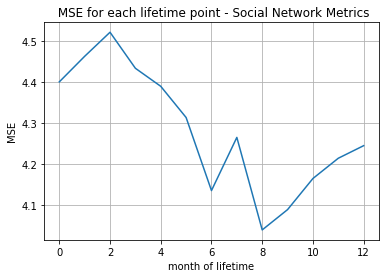

In [84]:
import matplotlib.pyplot as plt

month_list = [0,1,2,3,4,5,6,7,8,9,10,11,12]
MSE_list_SN  = MSE_list
fig, ax = plt.subplots()
ax.plot(month_list, MSE_list_SN,color='tab:blue',label='RF')

ax.set(xlabel='month of lifetime', ylabel='MSE',
       title=' MSE for each lifetime point - Social Network Metrics')
ax.grid()

plt.show()

# Q12

In [96]:
venmo_reg_sn_sb = venmo_reg_sn.join(accum_profile_prop,['user','month'],how ='inner').orderBy('user','month').cache()

In [117]:
# Prepare for user and friend table with month interval
venmo_data.createOrReplaceTempView('venmo_data')

dynamic_friending = spark.sql("SELECT distinct user, friend, datetime\
                               FROM  \
                               (SELECT user1 as user, user2 as friend, datetime \
                               FROM venmo_data \
                               UNION \
                               SELECT user2 as user, user1 as friend, datetime \
                               FROM venmo_data) ")
dynamic_friending.createOrReplaceTempView('dynamic_friending')

In [ ]:
# create user and friend table with month interval
window = Window.partitionBy('user').orderBy('datetime')
dynamic_friending = dynamic_friending.withColumn("month_passed", F.ceil((F.datediff(dynamic_friending.datetime, 
                                   first(dynamic_friending.datetime).over(window)))/30) )

In [ ]:
# Calculate the users' spending behavior of his/her social network
dynamic_friending.createOrReplaceTempView("dynamic_friending")
venmo_reg_sn_sb.createOrReplaceTempView("venmo_reg_sn_sb")
venmo_reg_sn = spark.sql("""
                SELECT v1.user, v1.month, v1.Y, v1.recency, v1.frequency, 
                v1.friend_degree, v1.fof_degree, v1.clustering_coefficient,
                v1.pagerank, 
                AVG(v2.activity_perc) as activity_perc,
                AVG(v2.food_perc) as food_perc,
                AVG(v2.illegal_perc) as illegal_perc,
                AVG(V2.others_perc) as others_perc,
                AVG(V2.people_perc) as people_perc,
                AVG(V2.utility_perc) as utility_perc,
                AVG(V2.cash_perc) as cash_perc ,
                AVG(V2.event_perc) as event_perc,
                AVG(V2.transp_perc) as transp_perc
                FROM venmo_reg_sn_sb v1 LEFT JOIN dynamic_friending f
                ON v1.user = f.user 
                LEFT JOIN venmo_reg_sn_sb v2
                ON f.friend = v2.user
                group by v1.user, v1.month, v1.Y, v1.recency, v1.frequency, 
                v1.friend_degree, v1.fof_degree, v1.clustering_coefficient,
                v1.pagerank
                """)

In [99]:
# Change the dataframe into the model suitable format
vectorAssembler = VectorAssembler(inputCols = ['friend_degree','fof_degree','clustering_coefficient','pagerank','activity_perc','food_perc','illegal_perc','others_perc','people_perc','utility_perc','cash_perc','event_perc','transp_perc','travel_perc'], outputCol = 'features')
venmo_reg_sn_sb_agg = vectorAssembler.transform(venmo_reg_sn_sb)
venmo_reg_sn_sb_agg.show()
venmo_reg_sn_sb_agg.write.parquet('venmo_reg_sn_sb_agg.parquet',mode='overwrite')

+----+-----+---+-------+--------------------+-------------+----------+----------------------+--------------------+-------------+---------+------------+-----------+-----------+------------+---------+----------+-----------+-----------+--------------------+
|user|month|  Y|recency|           frequency|friend_degree|fof_degree|clustering_coefficient|            pagerank|activity_perc|food_perc|illegal_perc|others_perc|people_perc|utility_perc|cash_perc|event_perc|transp_perc|travel_perc|            features|
+----+-----+---+-------+--------------------+-------------+----------+----------------------+--------------------+-------------+---------+------------+-----------+-----------+------------+---------+----------+-----------+-----------+--------------------+
|   3|    0|  6|      0|                 1.0|            1|         1|                   0.0|1.051380846943575...|          0.0|      0.0|         0.0|        0.5|        0.5|         0.0|      0.0|       0.0|        0.0|        0.0|(1

In [100]:
venmo_reg_sn_sb_agg = spark.read.parquet('venmo_reg_sn_sb_agg.parquet')
# Train and test split
for i in range(0,13):
    splits = venmo_reg_sn_sb_agg[venmo_reg_sn_sb_agg['month']==i].randomSplit([0.7, 0.3])
    train = splits[0].select(['features','Y'])
    test = splits[1].select(['features','Y'])
    train_df = train.withColumnRenamed('Y','label')
    test_df = test.withColumnRenamed('Y','label')
    train_df.write.parquet("train_df_sn_sb_month"+str(i)+".parquet", mode='overwrite')
    test_df.write.parquet("test_df_sn_sb_month"+str(i)+".parquet", mode='overwrite')

In [101]:
MSE_list = []
for i in range(0,13):  
    # For each user’s lifetime point, regress her social network metrics and the spending behavior of her social network on Y.
    lr = LinearRegression(featuresCol='features', labelCol='label', maxIter=10)

    # We use a ParamGridBuilder to construct a grid of parameters to search over.
    # TrainValidationSplit will try all combinations of values and determine best model using the evaluator.
    paramGrid = ParamGridBuilder()\
        .addGrid(lr.regParam, [0.1, 0.01]) \
        .addGrid(lr.fitIntercept, [False, True])\
        .addGrid(lr.elasticNetParam, [0.0, 0.5, 1.0])\
        .build()

    # A TrainValidationSplit requires an Estimator, a set of Estimator ParamMaps, and an Evaluator.
    tvs = TrainValidationSplit(estimator=lr,
                               estimatorParamMaps=paramGrid,
                               evaluator=RegressionEvaluator(),
                               # 80% of the data will be used for training, 20% for validation.
                               trainRatio=0.8)

    # Run TrainValidationSplit, and choose the best set of parameters.
    train_df = spark.read.parquet("train_df_sn_sb_month"+str(i)+".parquet")
    test_df = spark.read.parquet("test_df_sn_sb_month"+str(i)+".parquet")
    model = tvs.fit(train_df)
    
    # Out of Sample Mean Squared Error
    lr_predictions = model.transform(test_df)
    evaluator = RegressionEvaluator(metricName="mse")
    MSE = evaluator.evaluate(lr_predictions)
    MSE_list.append(MSE)
    
    #
    print(i)
    print("Coefficients: " + str(model.bestModel.coefficients))

0
Coefficients: [-0.9333079251233578,0.008551654904085465,1.544563793544064,1299516.501472694,-0.2881218469002382,0.10216759941315486,0.27765252856317396,0.0254336242294495,0.06425717842672128,0.07005240040065125,-0.09709225762774265,-0.20476537285524515,0.0059536401421629356,-0.2597067487524151]
1
Coefficients: [0.3665314748858177,0.010827861450187512,3.04001622582056,497168.0031244733,1.4682438551857349,1.8592956025385474,2.1836004372223914,1.7085164015343628,1.7026242700103666,1.629742906436134,1.7498995793978436,1.5196747281947396,1.5127711472270453,1.0341062340997154]
2
Coefficients: [0.5801104469391556,0.017243803692731506,4.239739881640447,450189.2542442128,1.5092753597145627,2.0640095529524127,2.2755714239354554,1.8847736881476116,1.8218866751772353,1.671793323231235,1.960065372038565,1.6781321624583276,1.796156659352344,1.5401924354750325]
3
Coefficients: [0.681949122861122,0.012920966004917279,4.668675932018795,429866.4368689526,1.7121300573182054,2.1952648745643555,2.4376458

In [103]:
MSE_list

[4.356348643583914,
 4.143620686804036,
 4.12542120970357,
 4.090625480132508,
 3.869305915064894,
 3.820154841856605,
 3.7855401214625455,
 3.783739624105783,
 3.7542736746539007,
 3.891081413737133,
 3.9179867377774857,
 3.9418549879996596,
 4.03583283699032]

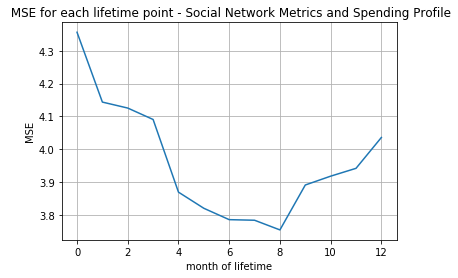

In [105]:
import matplotlib.pyplot as plt

month_list = [0,1,2,3,4,5,6,7,8,9,10,11,12]
MSE_list_SN_SB  = MSE_list
fig, ax = plt.subplots()
ax.plot(month_list, MSE_list_SN,color='tab:blue',label='RF')

ax.set(xlabel='month of lifetime', ylabel='MSE',
       title=' MSE for each lifetime point - Social Network Metrics and Spending Profile')
ax.grid()

plt.show()